In [8]:
import os
import joblib
import unet
from glob import glob
import torch
import warnings
from tqdm import tqdm
from skimage.io import imread, imsave
import matplotlib
from skimage.io import imsave
import SimpleITK as sitk
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.figure import Figure 
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.nn.functional as F



In [9]:
def predicting(filepath,filename):
    print("predicting")
    model = unet.Unet("1")
    model.load_state_dict(torch.load("./models/jiu0Monkey_Unet_woDS/model.pth", map_location=torch.device('cuda')))
    model.to("cuda")
    try:
        data1 = np.load(filepath,allow_pickle=True) 
    except FileNotFoundError as e:
        print(e)
        return [[[0]]],[[[0]]]
    
    data2 = data1[:, :, 0:4]
    data2 = np.where(data2<-8, -2.67, data2)
    data2 = data2+2.67
    data2 = data2/6
    
    data1 = data1.T
    data1 = np.expand_dims(data1,0)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    img = torch.from_numpy(data1).type(torch.FloatTensor).to(device)
    model.eval()

    with torch.no_grad():
        img = img.cuda()
        output = model(img)
        output = torch.sigmoid(output).cpu().detach().numpy()
        np.save('test.npy', output)

    for i in range(output.shape[0]):
        rgbPic = np.zeros([160, 160, 3], dtype=np.uint8)
        for idx in range(output.shape[2]):
            for idy in range(output.shape[3]):
                if output[i,0,idx,idy] > 0.5:
                    rgbPic[idx, idy, 0] = 0
                    rgbPic[idx, idy, 1] = 128
                    rgbPic[idx, idy, 2] = 0
                if output[i,1,idx,idy] > 0.5:
                    rgbPic[idx, idy, 0] = 255
                    rgbPic[idx, idy, 1] = 0
                    rgbPic[idx, idy, 2] = 0
                if output[i,2,idx,idy] > 0.5:
                    rgbPic[idx, idy, 0] = 255
                    rgbPic[idx, idy, 1] = 255
                    rgbPic[idx, idy, 2] = 0
        rgbPic = np.array(rgbPic)
        for i in range(3):
            rgbPic[:,:,i]=rgbPic[:,:,i].T
    return data2,rgbPic


In [19]:
def get_path_of_four_files(num_list,layer):
    """
    return: dict{"num":[t1,t2,tice,flair,npy]}
    """
    dir_list1=[]
    for i in num_list:
        path="/data0/BraTS2020/brats_test/BraTS20_Validation_{num}".format(num=i)
        dir_list1.append(path)
        print(path)
    
    files_dict = {}
    for num, i in zip(num_list,dir_list1):
        four_files_list = []
        for root, dirs, files in os.walk(i, topdown=False):
            for name in files:
                if "t1.nii" in name:
                    four_files_list.append(os.path.join(root, name))
                if "t2.nii" in name:
                    four_files_list.append(os.path.join(root, name))
                if "t1ce.nii" in name:
                    four_files_list.append(os.path.join(root, name))
                if "flair.nii" in name:
                    four_files_list.append(os.path.join(root, name))
        four_files_list.append("/data0/BraTS2020/testImage/BraTS20_Validation_{num}_{layer}.npy".format(num=num,layer=layer))
        files_dict[str(num)] = four_files_list
    print("地址获取成功")
#     print(files_dict)
    return files_dict


def read_data(path_dict):
    """
    return: dict{"num":[t1,t2,tice,flair,npy,predict]}
    """
    all_data_list={}
    for key in path_dict:
        data_list = []
        for file1 in path_dict[key]:
            # TODO 潜在bug os.walk 按照一定次序读取文件，但是这个东西怎么说呢？不能保证npy文件的路径是是列表中第五个元素
            if ".npy" in file1:
                data_list.append(1) # 这里不读数据，占第五个位，依靠update_data函数更新数据
                data_list.append(2) # predict数据占第六个位置
            else: 
                info = sitk.ReadImage(file1)
                data_array1 = sitk.GetArrayFromImage(info)
                data_list.append(data_array1)
        all_data_list[key]=data_list
        print(key,"文件读取")
#     print(all_data_list)
    return all_data_list

def update_data(data,dir_nums,layer):
    update_path_list=[]
    for i in dir_nums:
        npy_name = "/data0/BraTS2020/testImage/BraTS20_Validation_{num}_{layer}.npy".format(num=i,layer=layer)
        update_path_list.append(npy_name)
        pre_data,result_data = predicting(npy_name,"nothing")
        data[i][4]=pre_data # 更换npy预处理数据
        data[i][5]=result_data # 更换predict结果
    return update_path_list
    

def figure(data,layer):
    for key in data:
#         plt.rcParams['font.sans-serif']=['SimHei']
#         plt.rcParams['axes.unicode_minus'] = False
        plt.figure(dpi=300)
        plt.suptitle(layer)
#         plt.subplots_adjust(0, 0, 1, 1)
        plt.subplot(231)
        plt.axis("off")
        plt.imshow(data[key][0][layer],"gray")
        plt.title("flair",fontsize=7)
        plt.subplot(232)
        plt.axis("off")
        plt.imshow(data[key][1][layer],"gray")
        plt.title("t1",fontsize=7)
        plt.subplot(233)
        plt.axis("off")
        plt.imshow(data[key][2][layer],"gray")
        plt.title("t2",fontsize=7)
        plt.subplot(234)
        plt.axis("off")
        plt.imshow(data[key][3][layer],"gray")
        plt.title("t1ce",fontsize=7)
        plt.subplot(235)
        plt.axis("off")
        plt.imshow(data[key][4][:,:,0:3])
        plt.title("pre",fontsize=7)
        plt.subplot(236)
        plt.axis("off")
        plt.imshow(data[key][5])
        plt.title("result",fontsize=7)
        plt.suptitle("SD:"+key+str(layer),fontsize=9)
        plt.savefig("./image/six_{num}_{layer}".format(num=key,layer=layer))
        plt.show()
    


In [25]:
begin=100
end=114
layer=1 # 这个参数不需要动
dir_list=["{:0>3d}".format(i) for i in range(begin,end)]
path_data = get_path_of_four_files(dir_list,layer)
print("_________________")

img_data = read_data(path_data)
print("finish")

/data0/BraTS2020/brats_test/BraTS20_Validation_100
/data0/BraTS2020/brats_test/BraTS20_Validation_101
/data0/BraTS2020/brats_test/BraTS20_Validation_102
/data0/BraTS2020/brats_test/BraTS20_Validation_103
/data0/BraTS2020/brats_test/BraTS20_Validation_104
/data0/BraTS2020/brats_test/BraTS20_Validation_105
/data0/BraTS2020/brats_test/BraTS20_Validation_106
/data0/BraTS2020/brats_test/BraTS20_Validation_107
/data0/BraTS2020/brats_test/BraTS20_Validation_108
/data0/BraTS2020/brats_test/BraTS20_Validation_109
/data0/BraTS2020/brats_test/BraTS20_Validation_110
/data0/BraTS2020/brats_test/BraTS20_Validation_111
/data0/BraTS2020/brats_test/BraTS20_Validation_112
/data0/BraTS2020/brats_test/BraTS20_Validation_113
地址获取成功
_________________
100 文件读取
101 文件读取
102 文件读取
103 文件读取
104 文件读取
105 文件读取
106 文件读取
107 文件读取
108 文件读取
109 文件读取
110 文件读取
111 文件读取
112 文件读取
113 文件读取
finish


predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


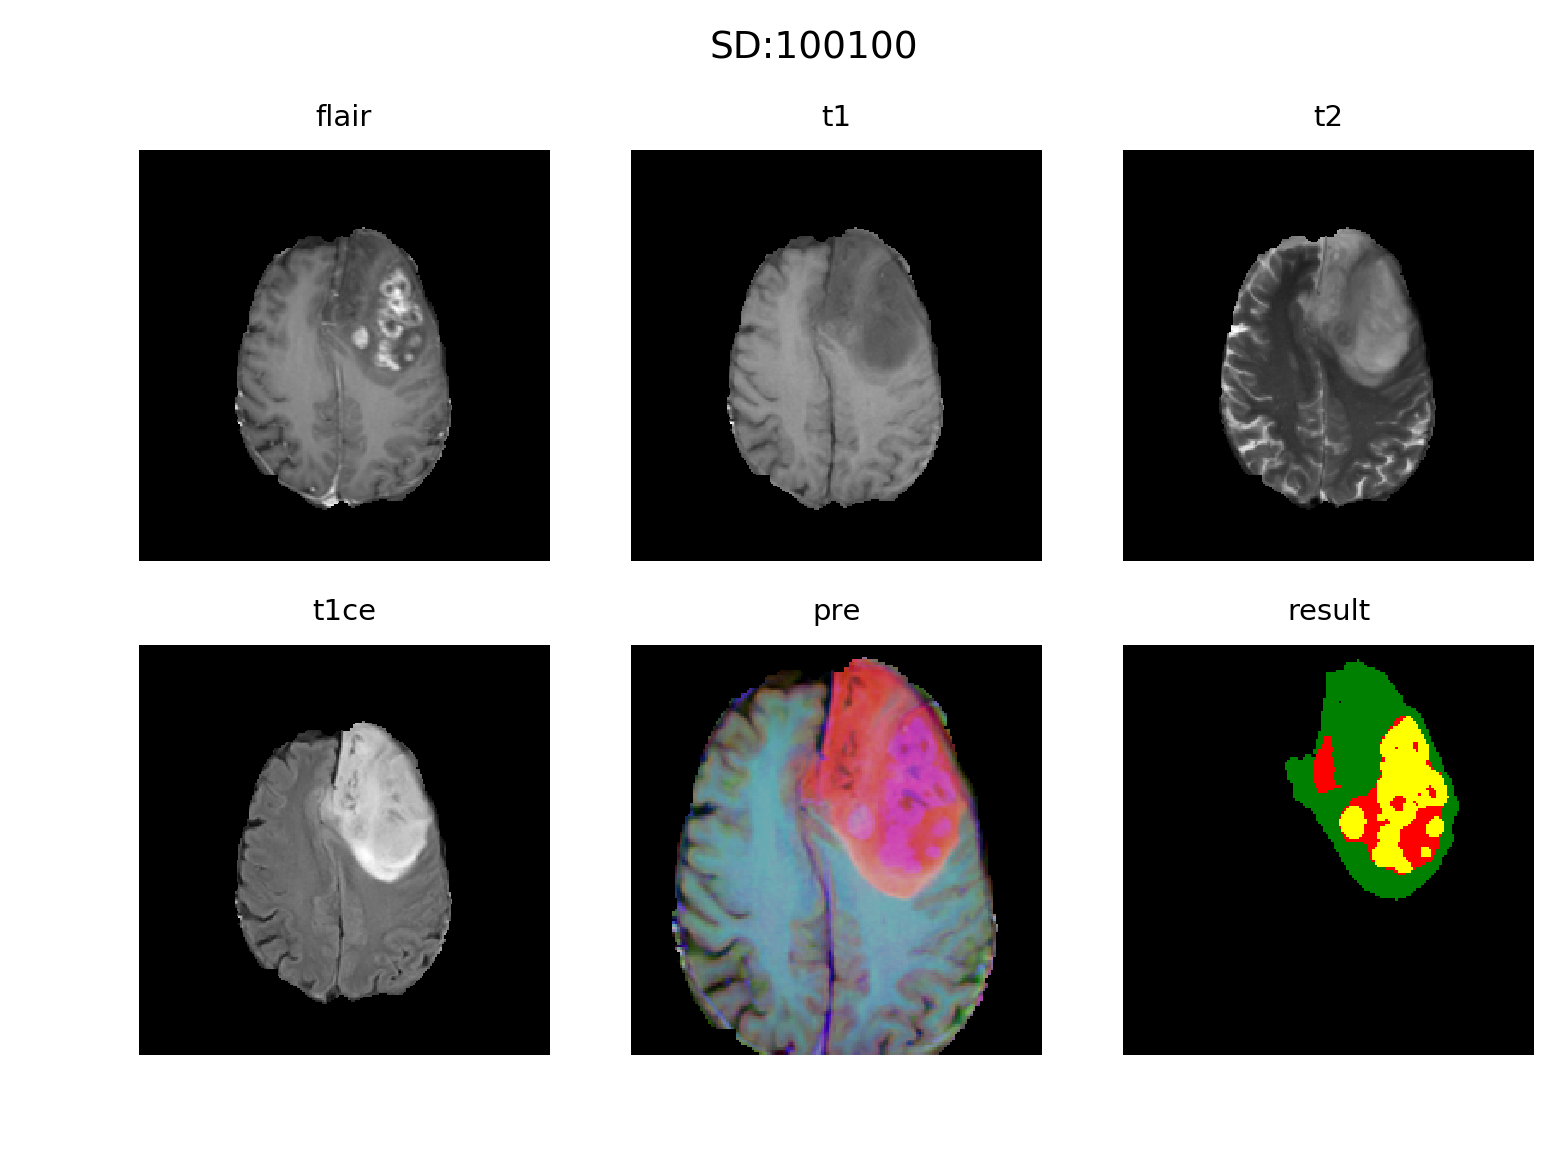

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


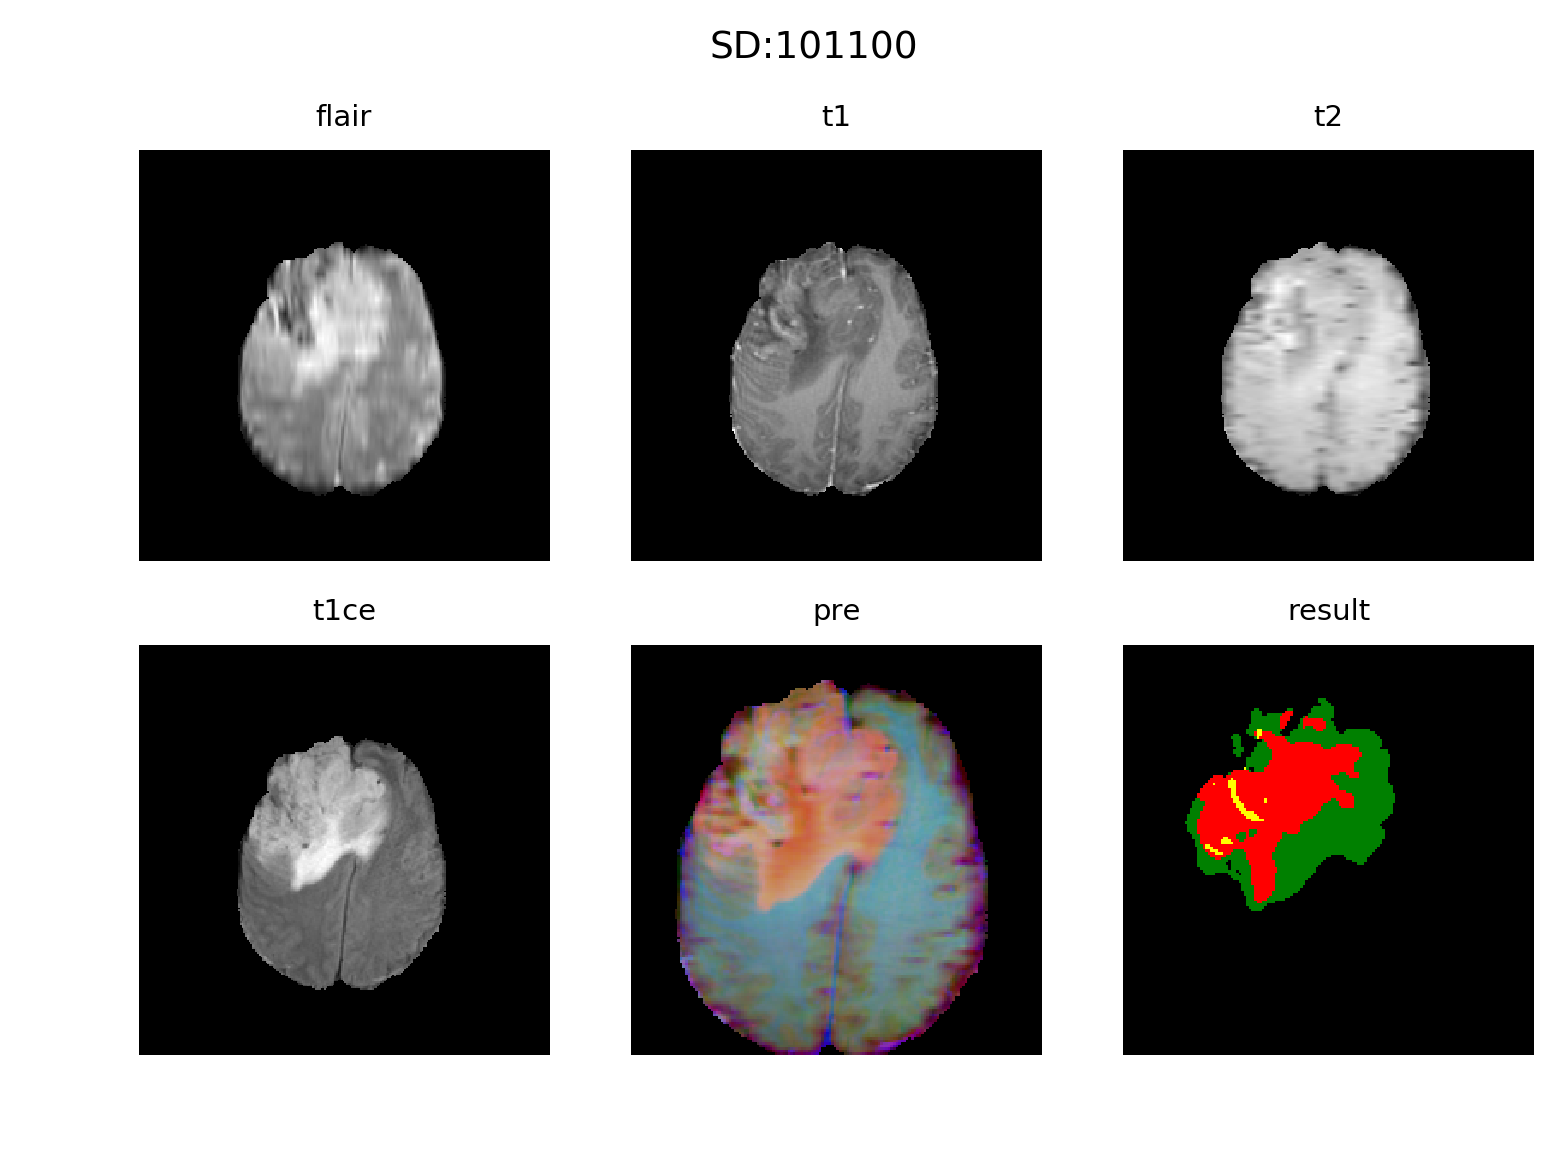

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


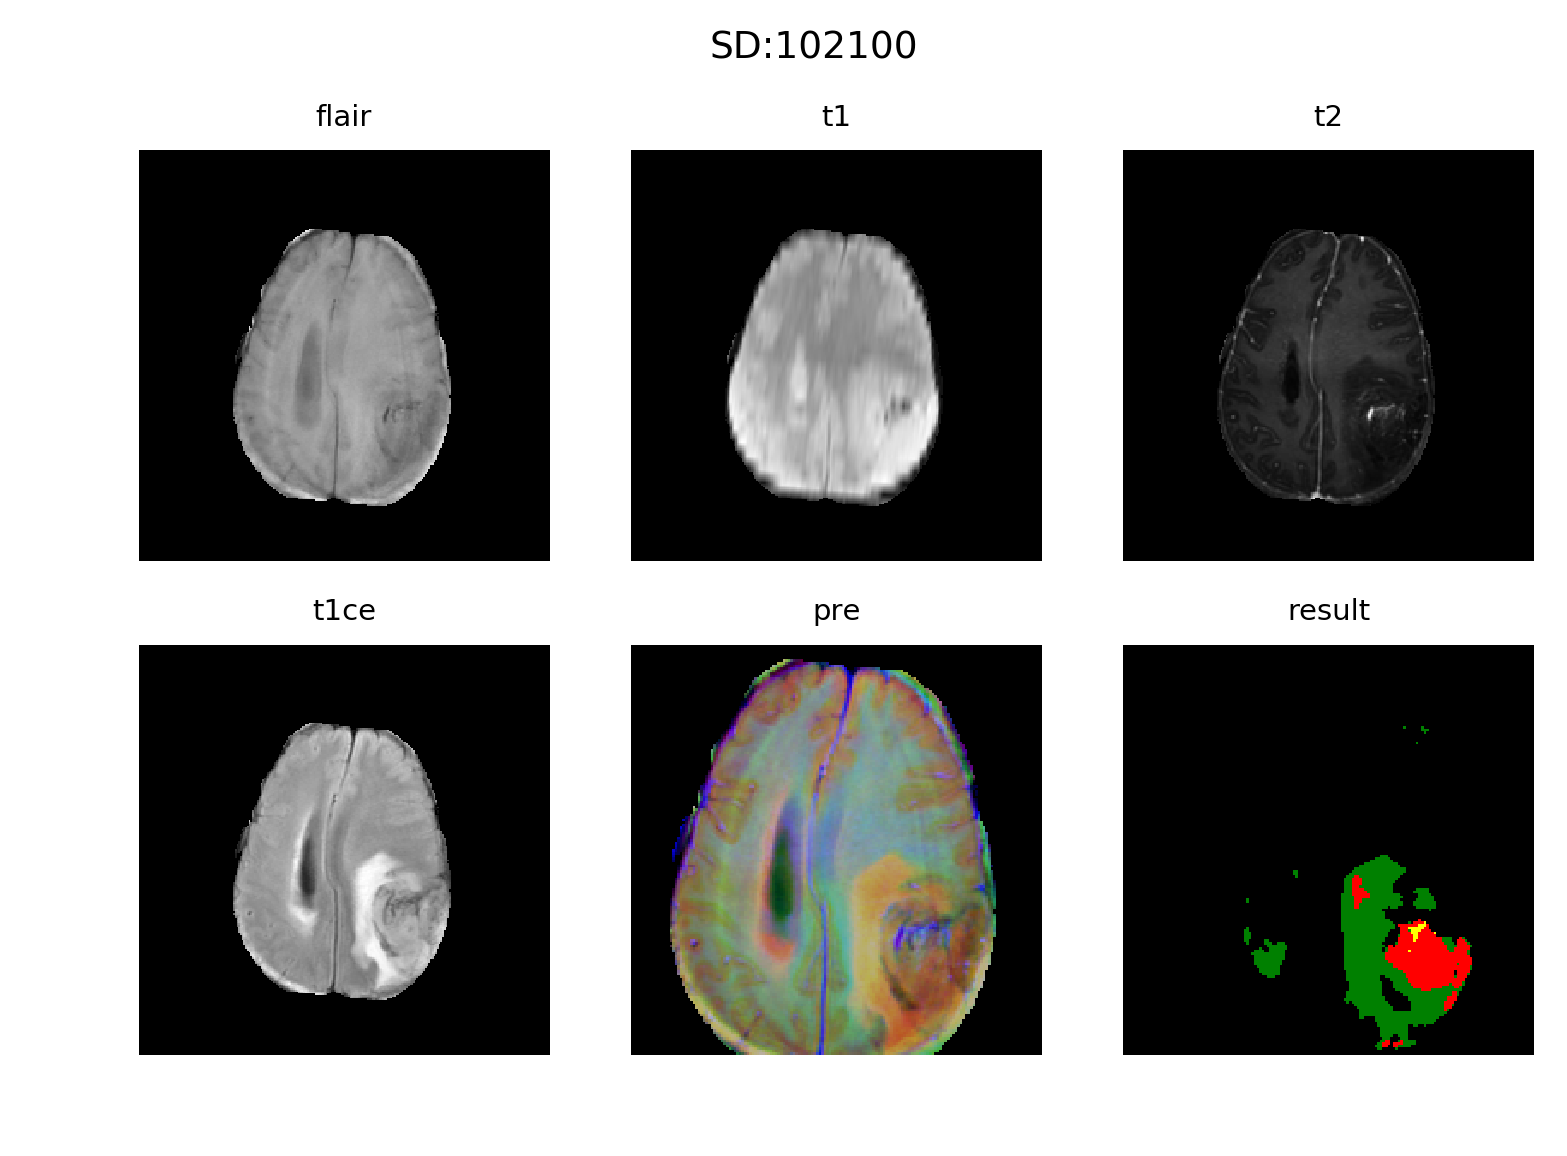

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


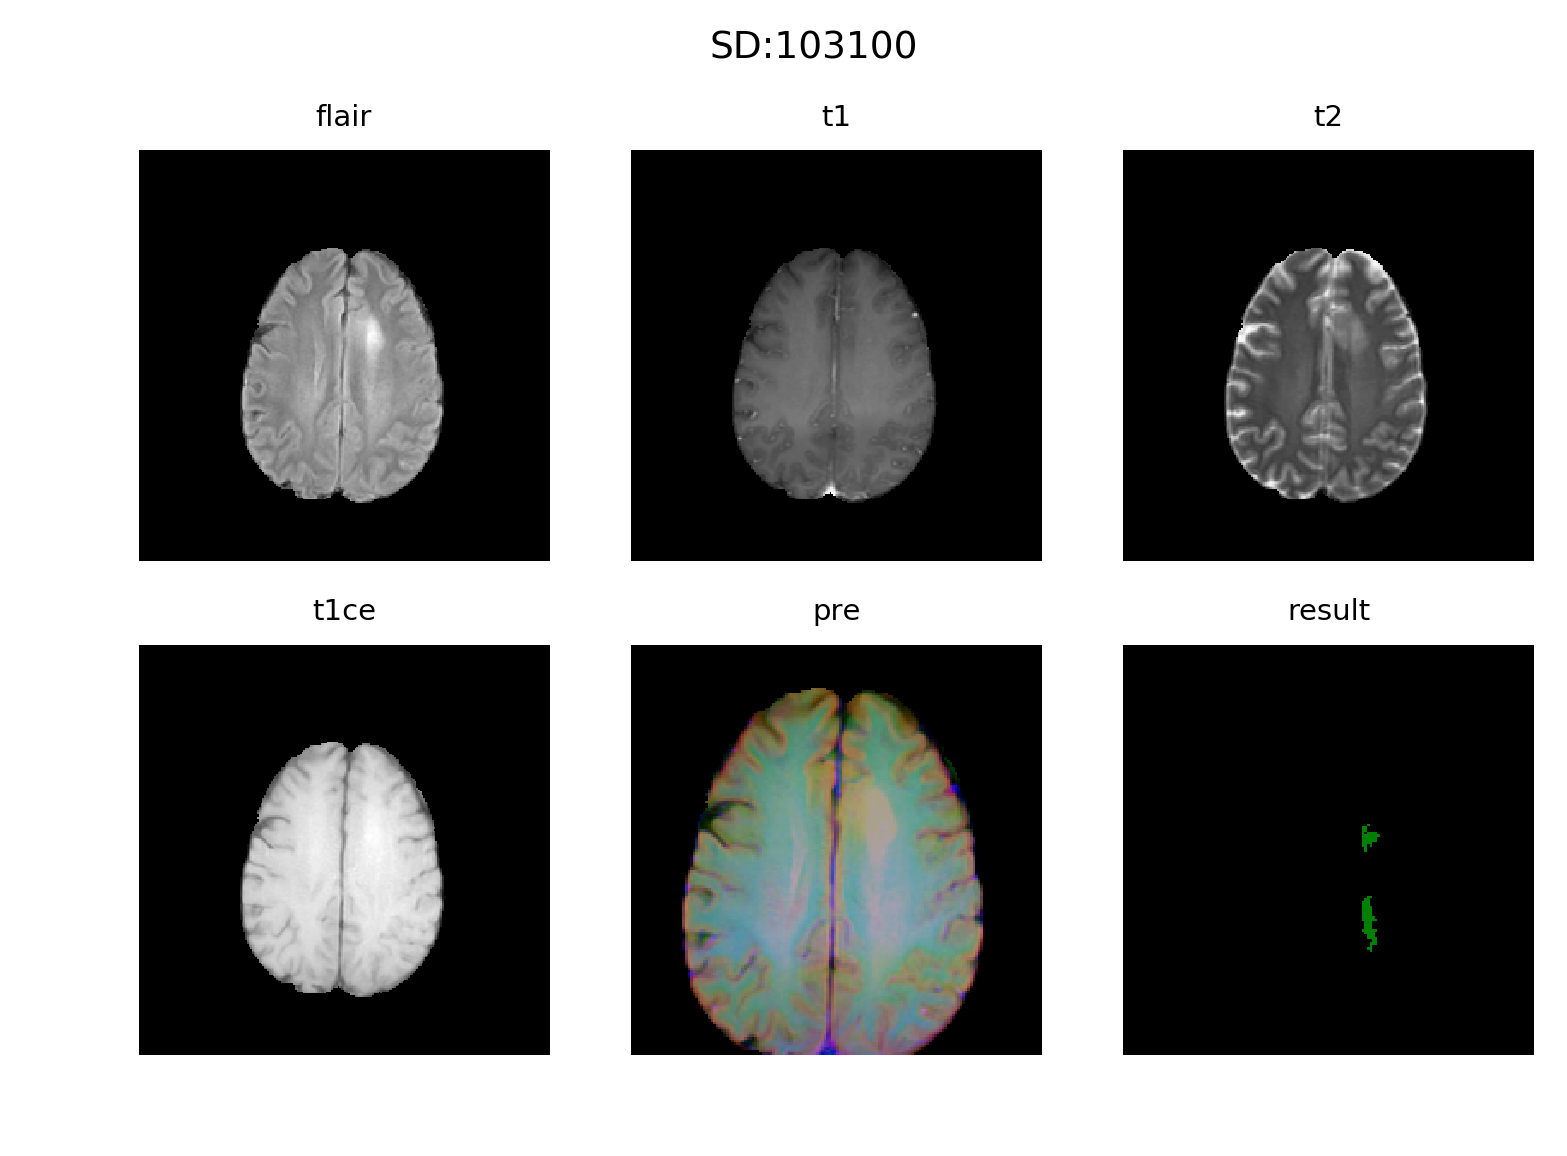

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


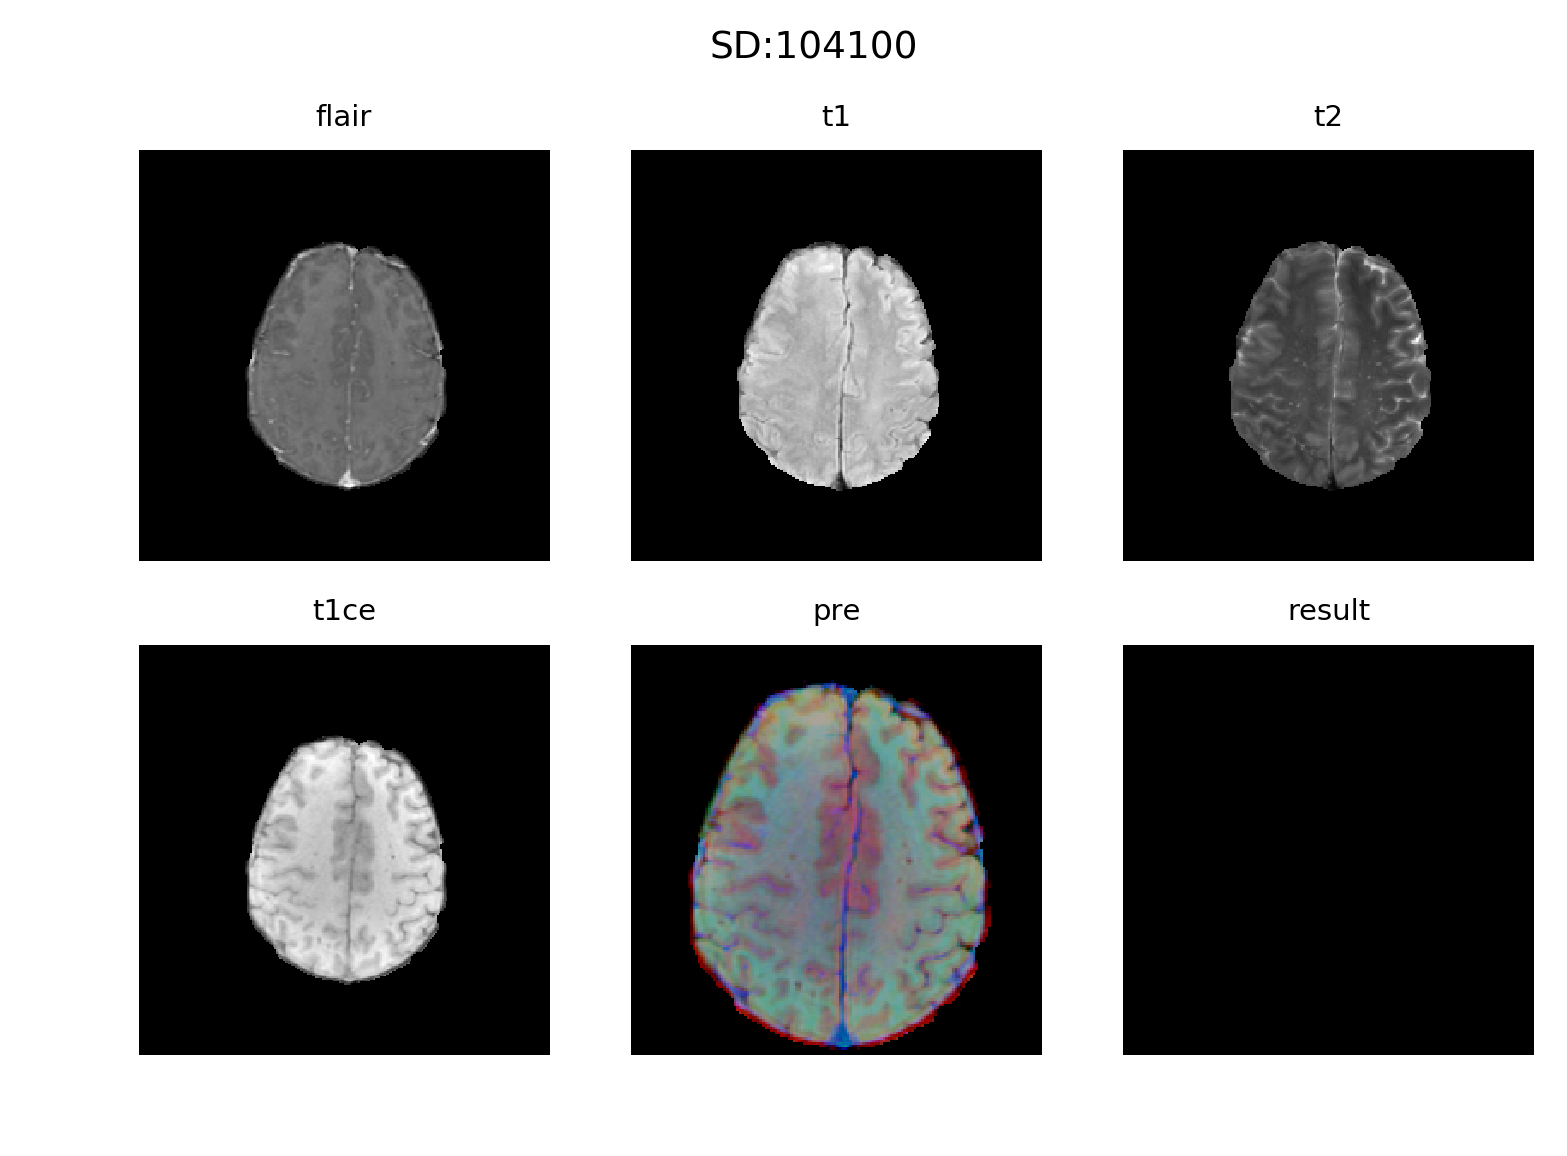

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


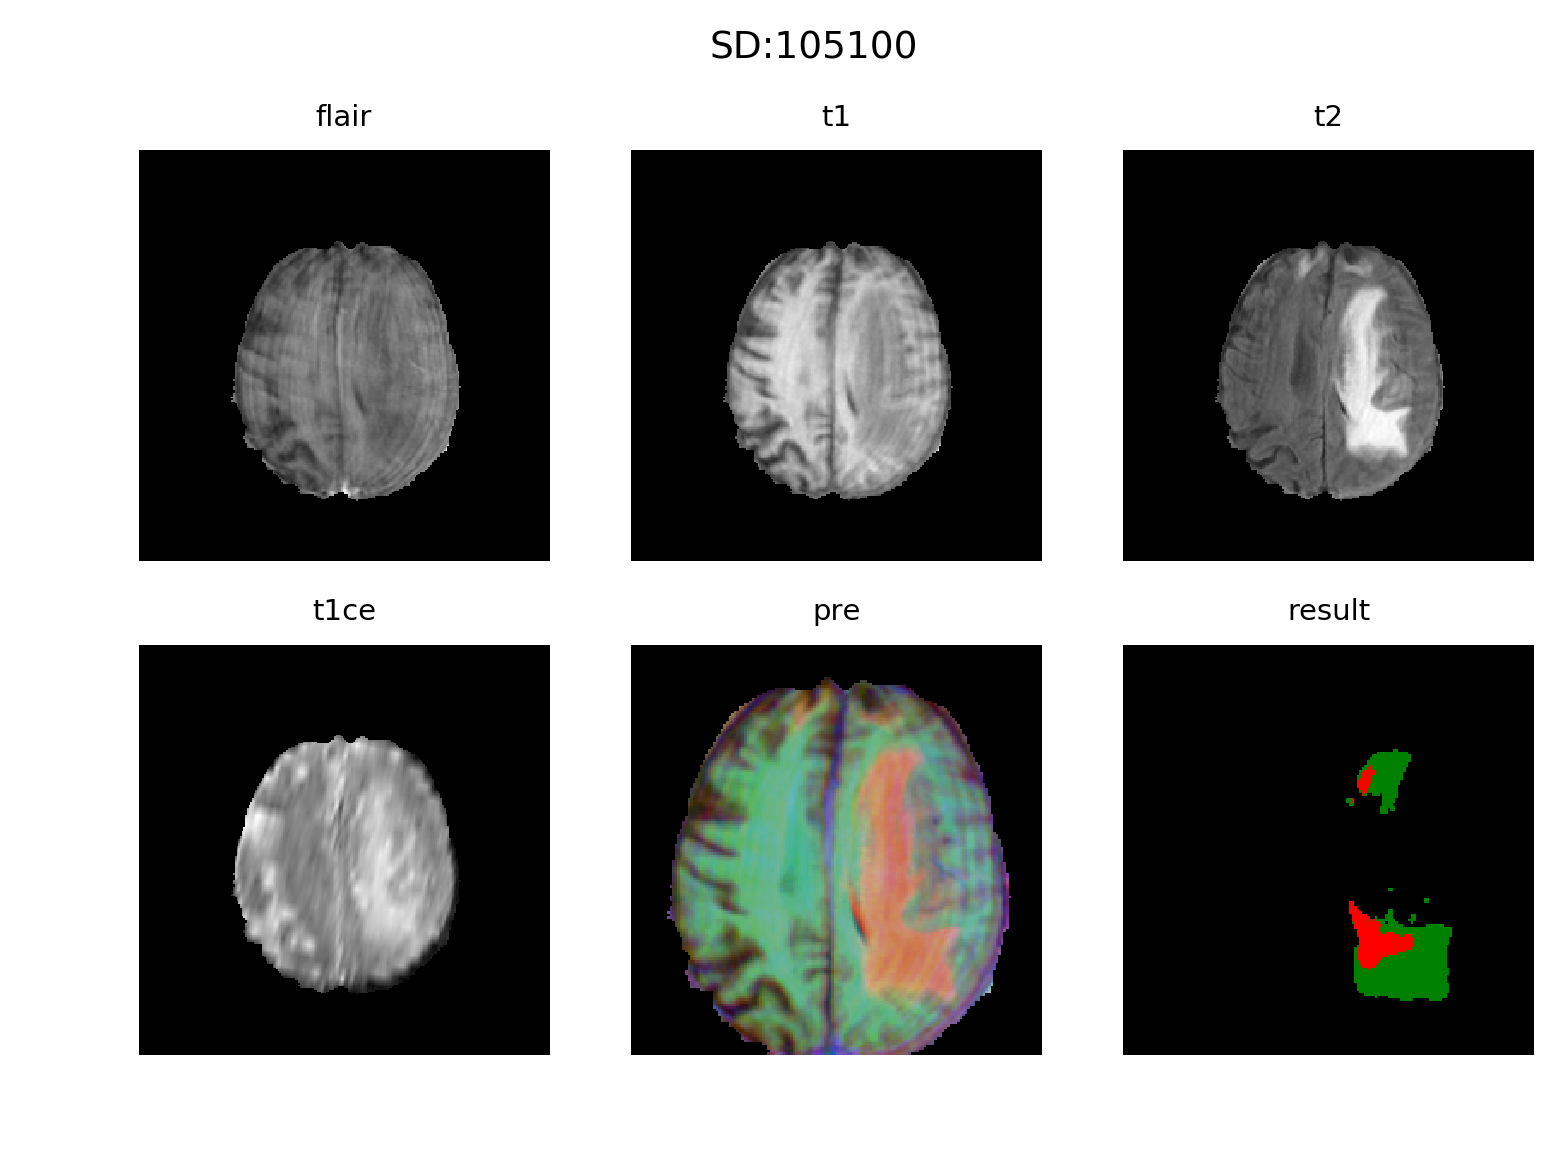

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


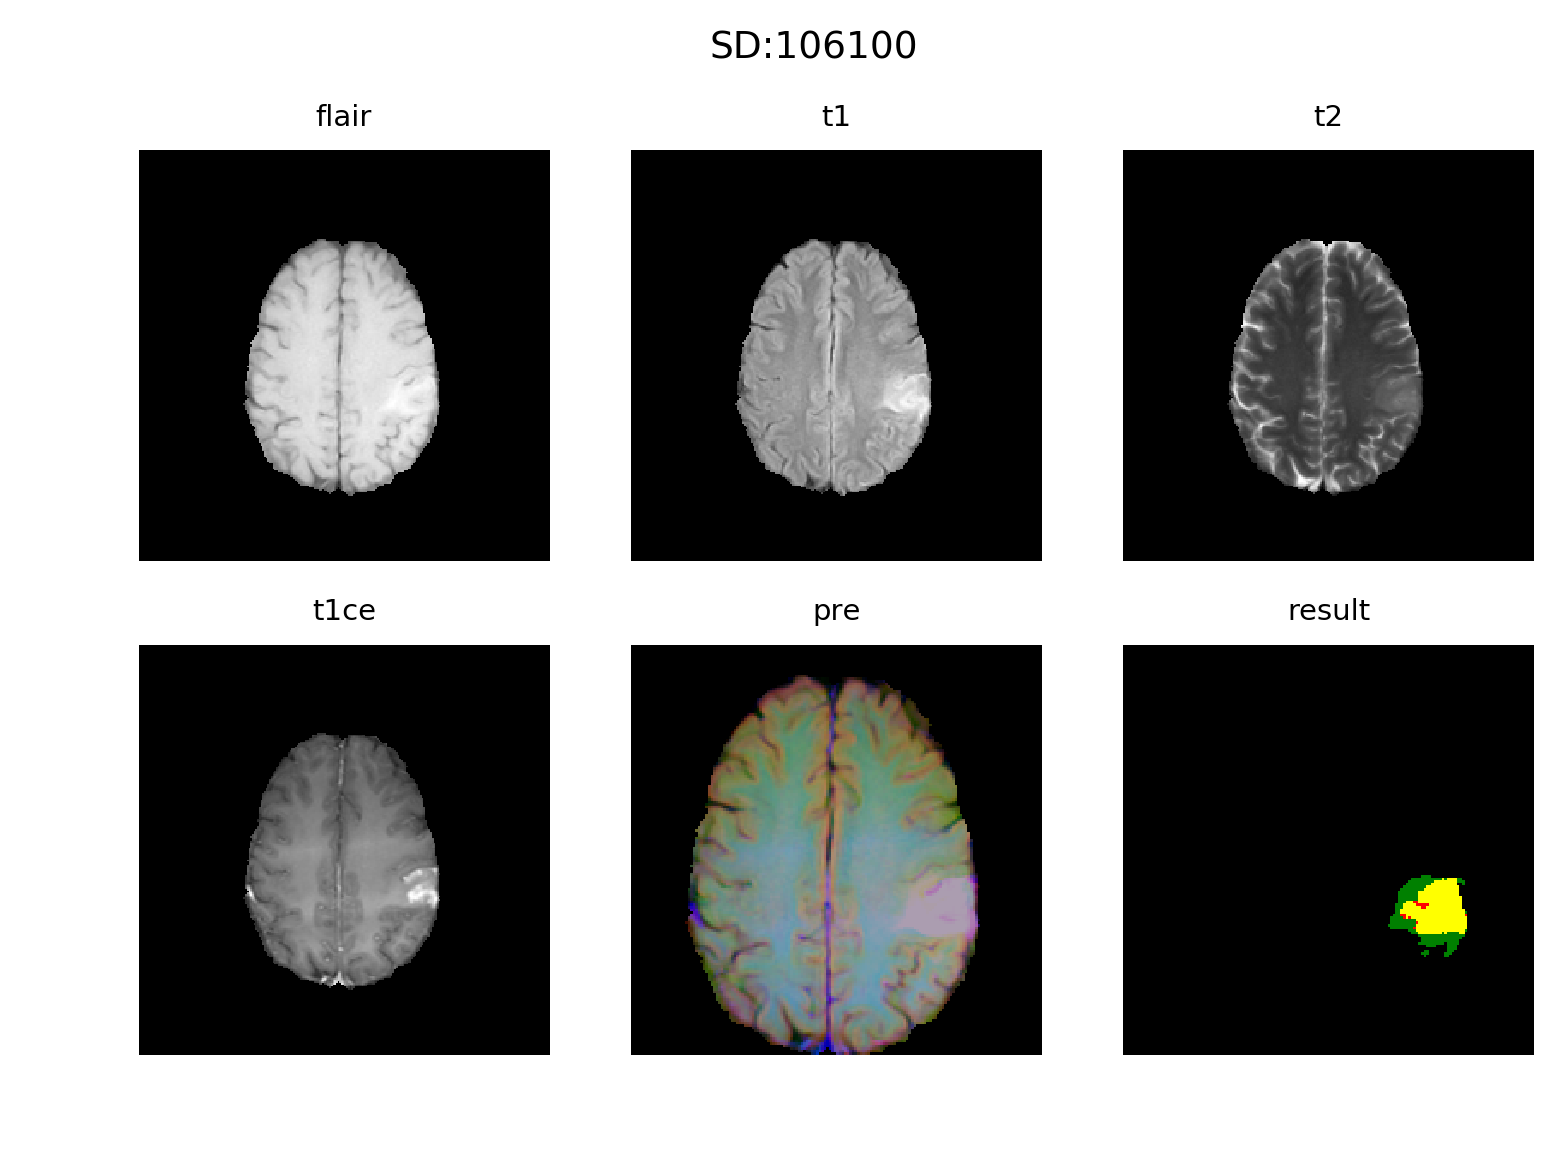

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


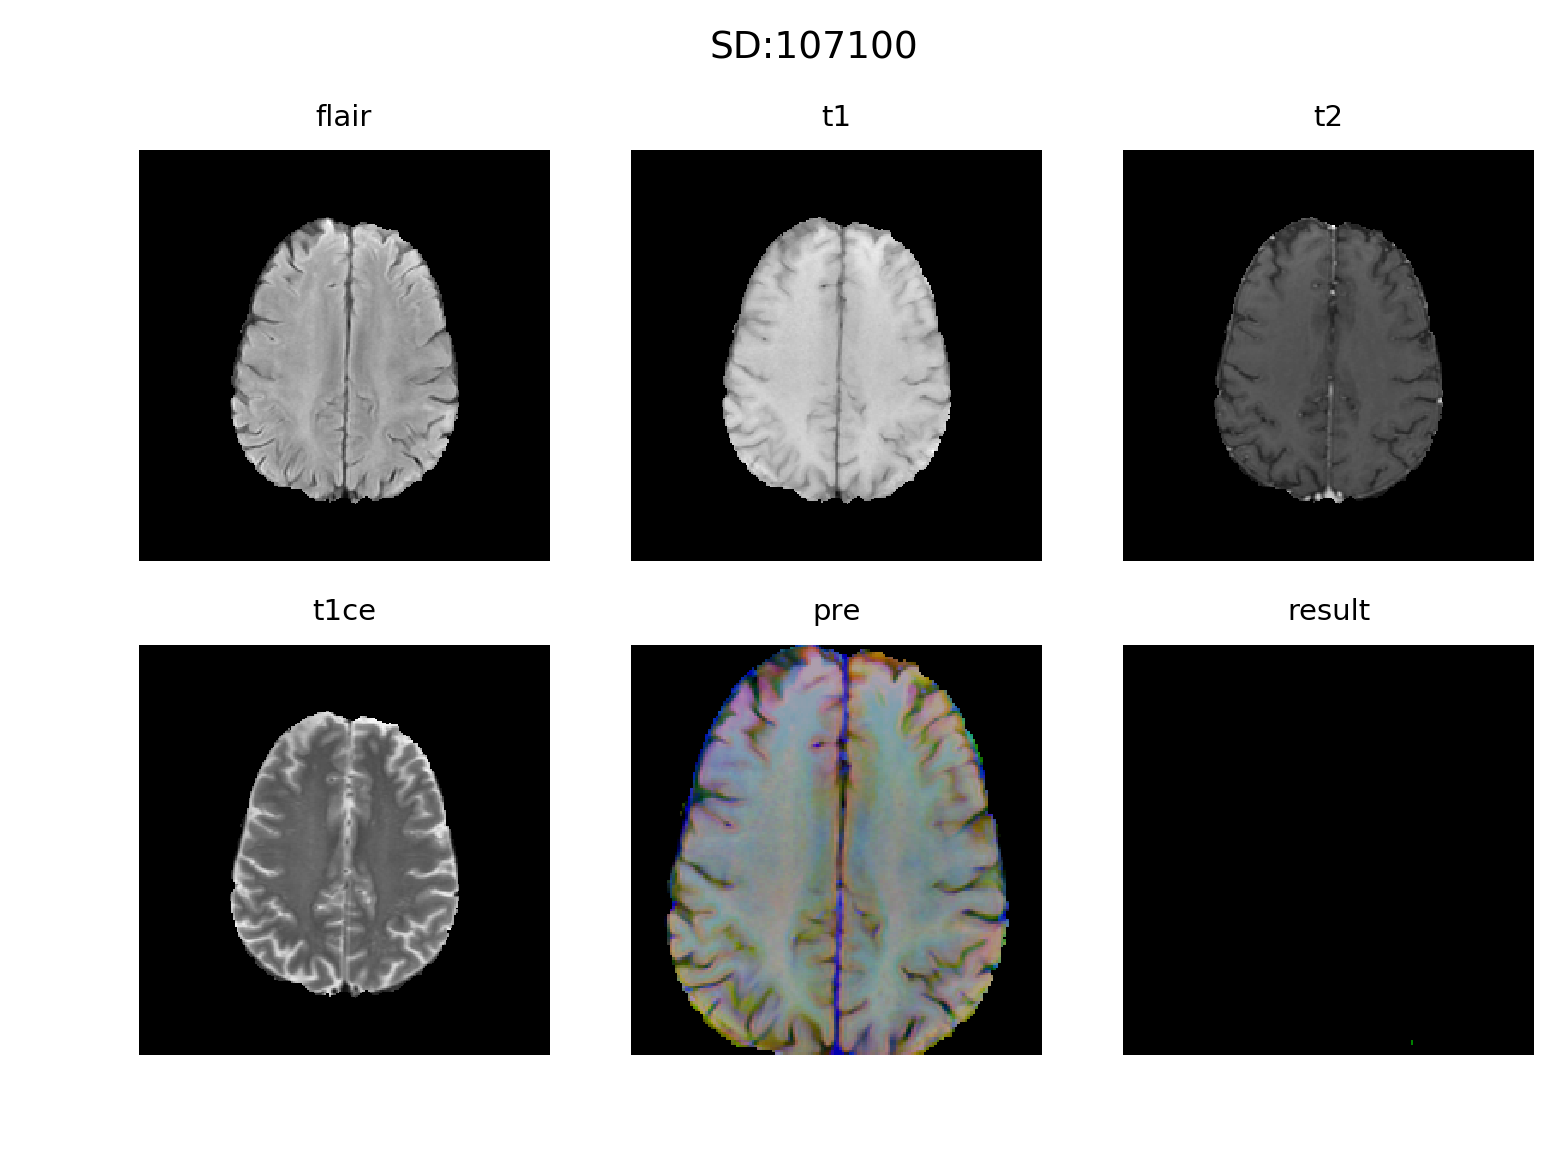

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


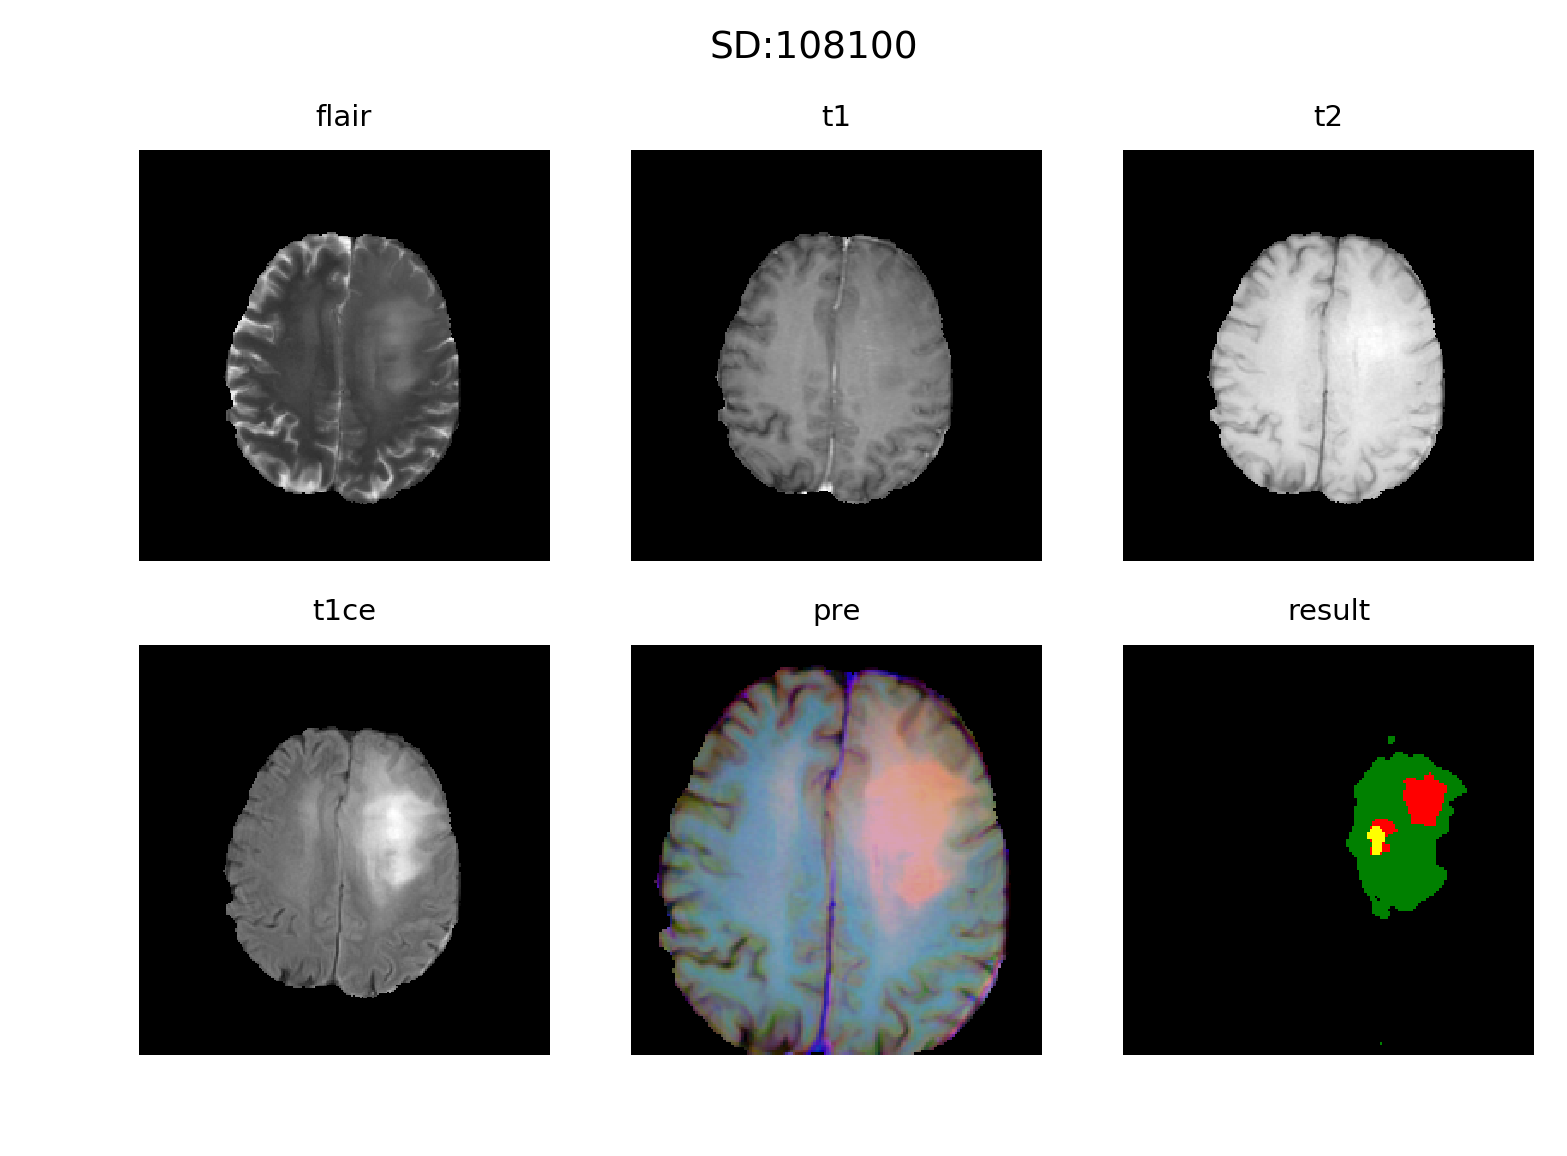

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


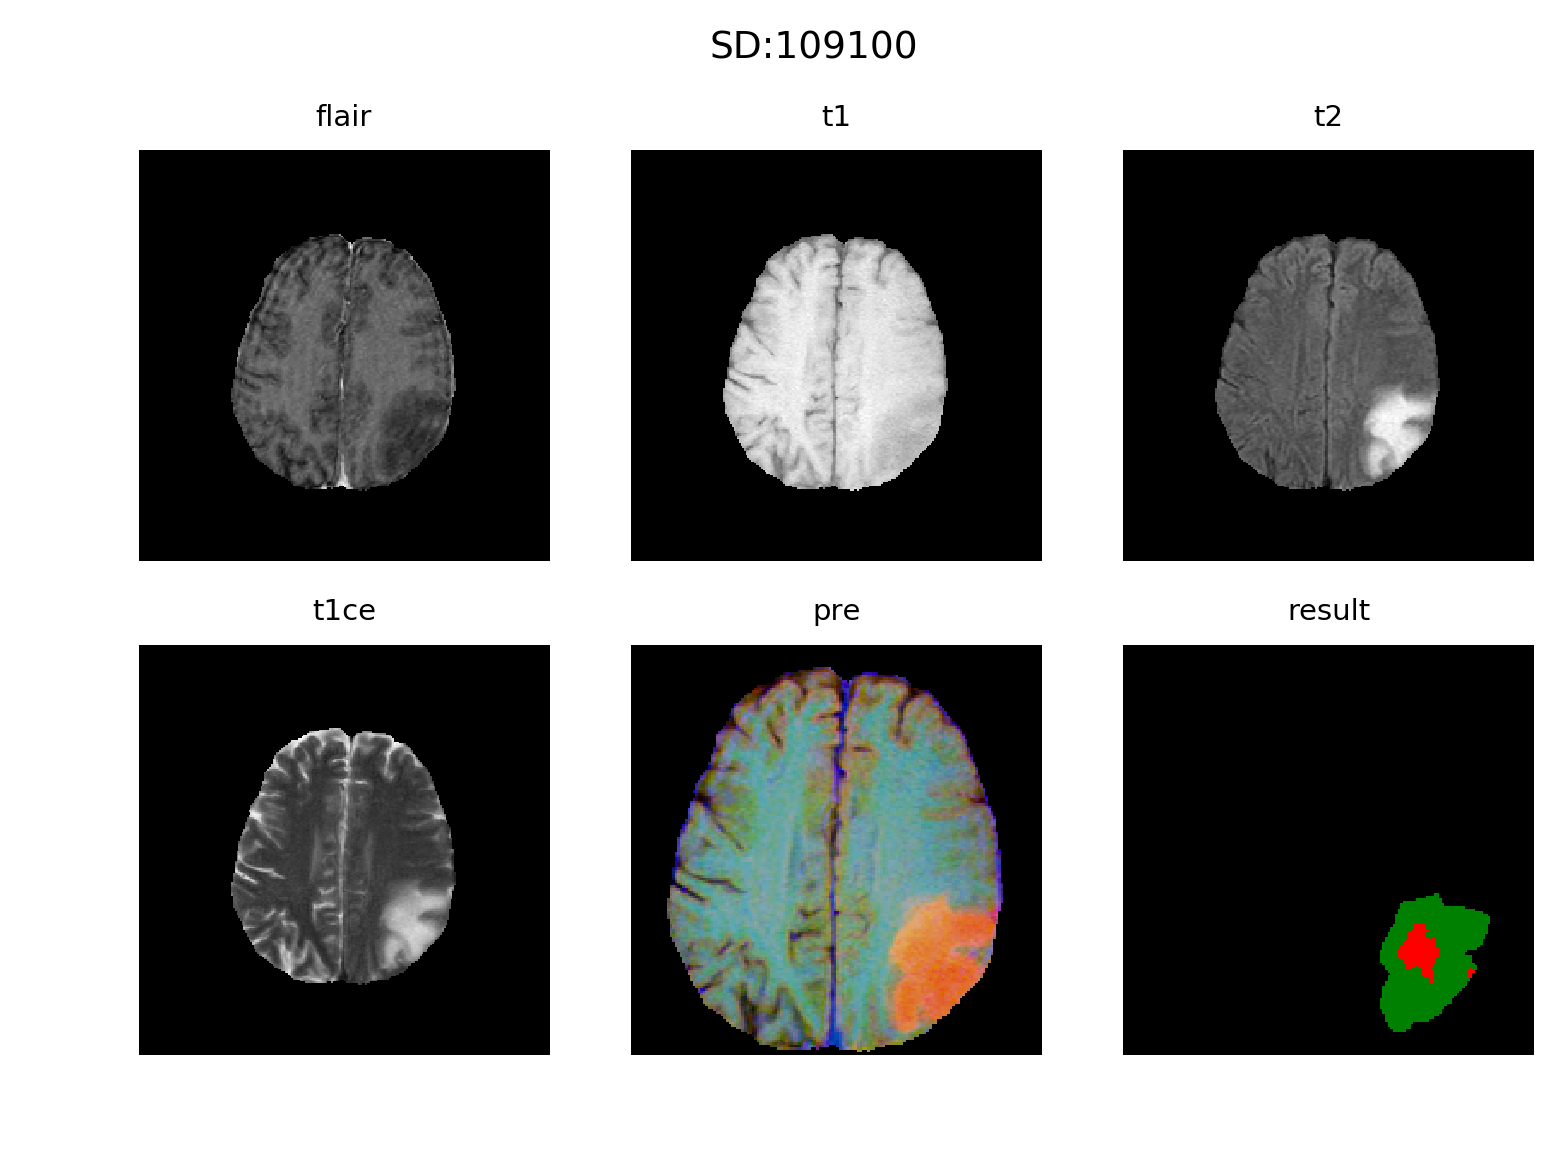

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


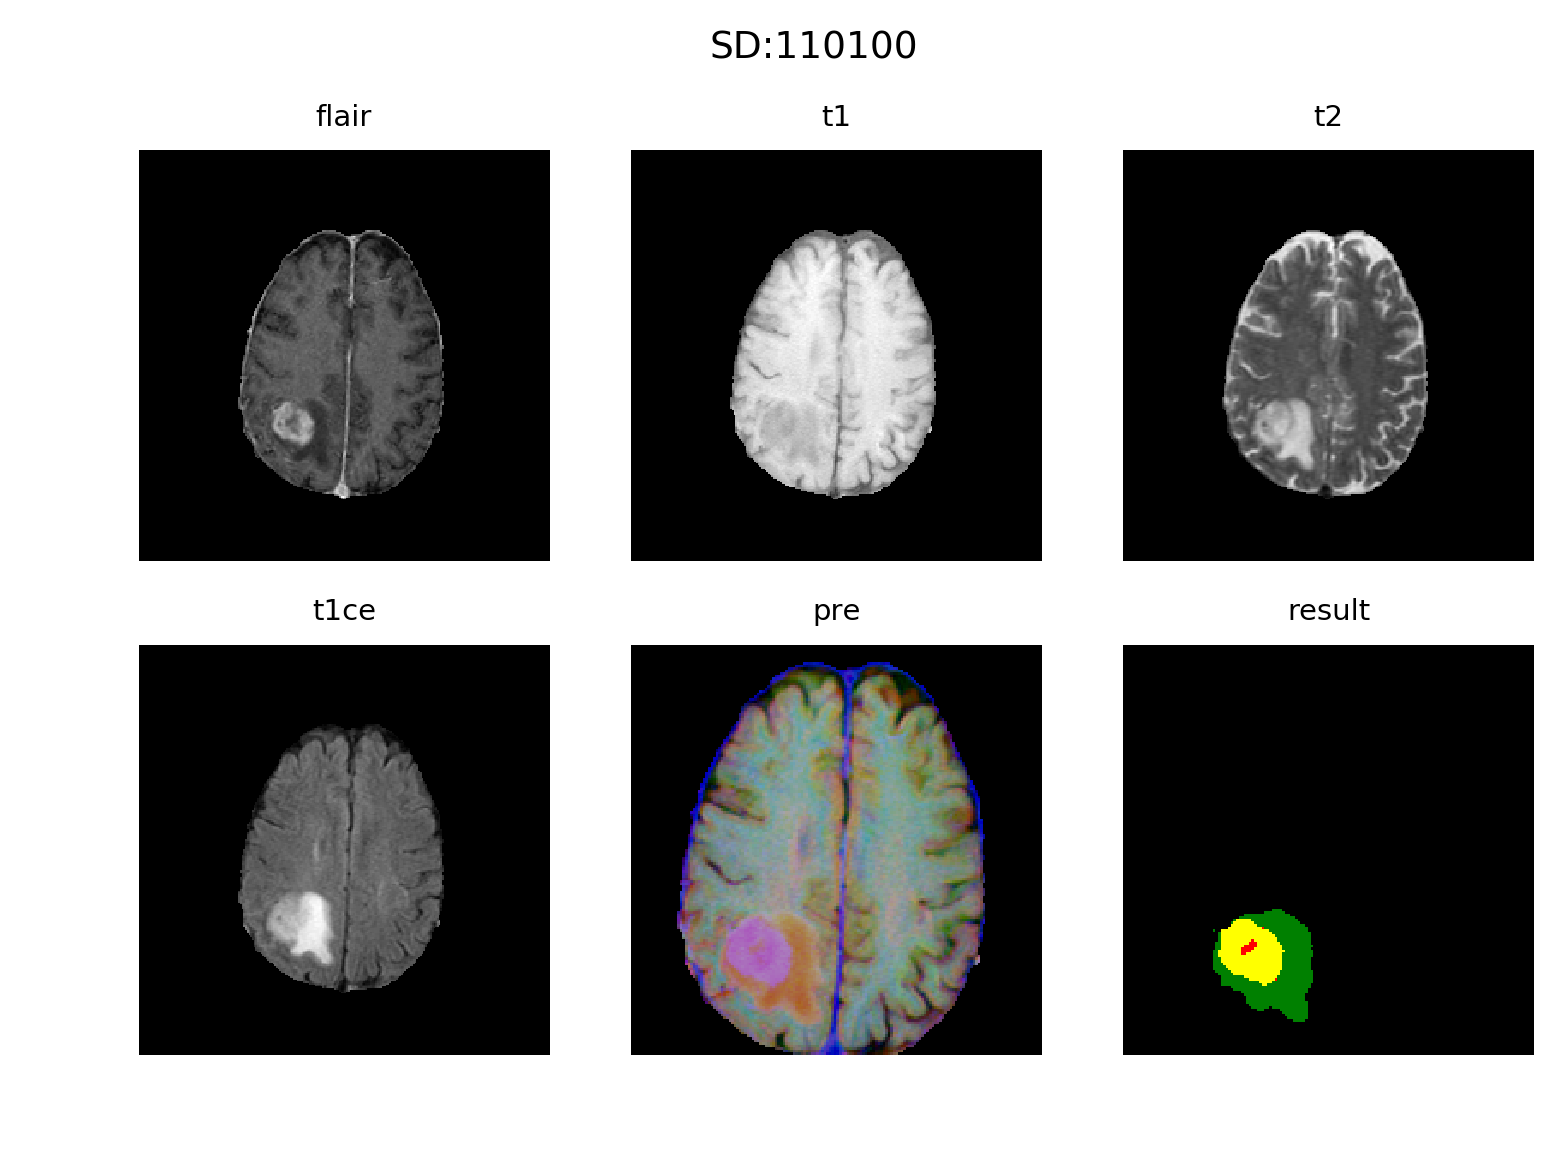

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


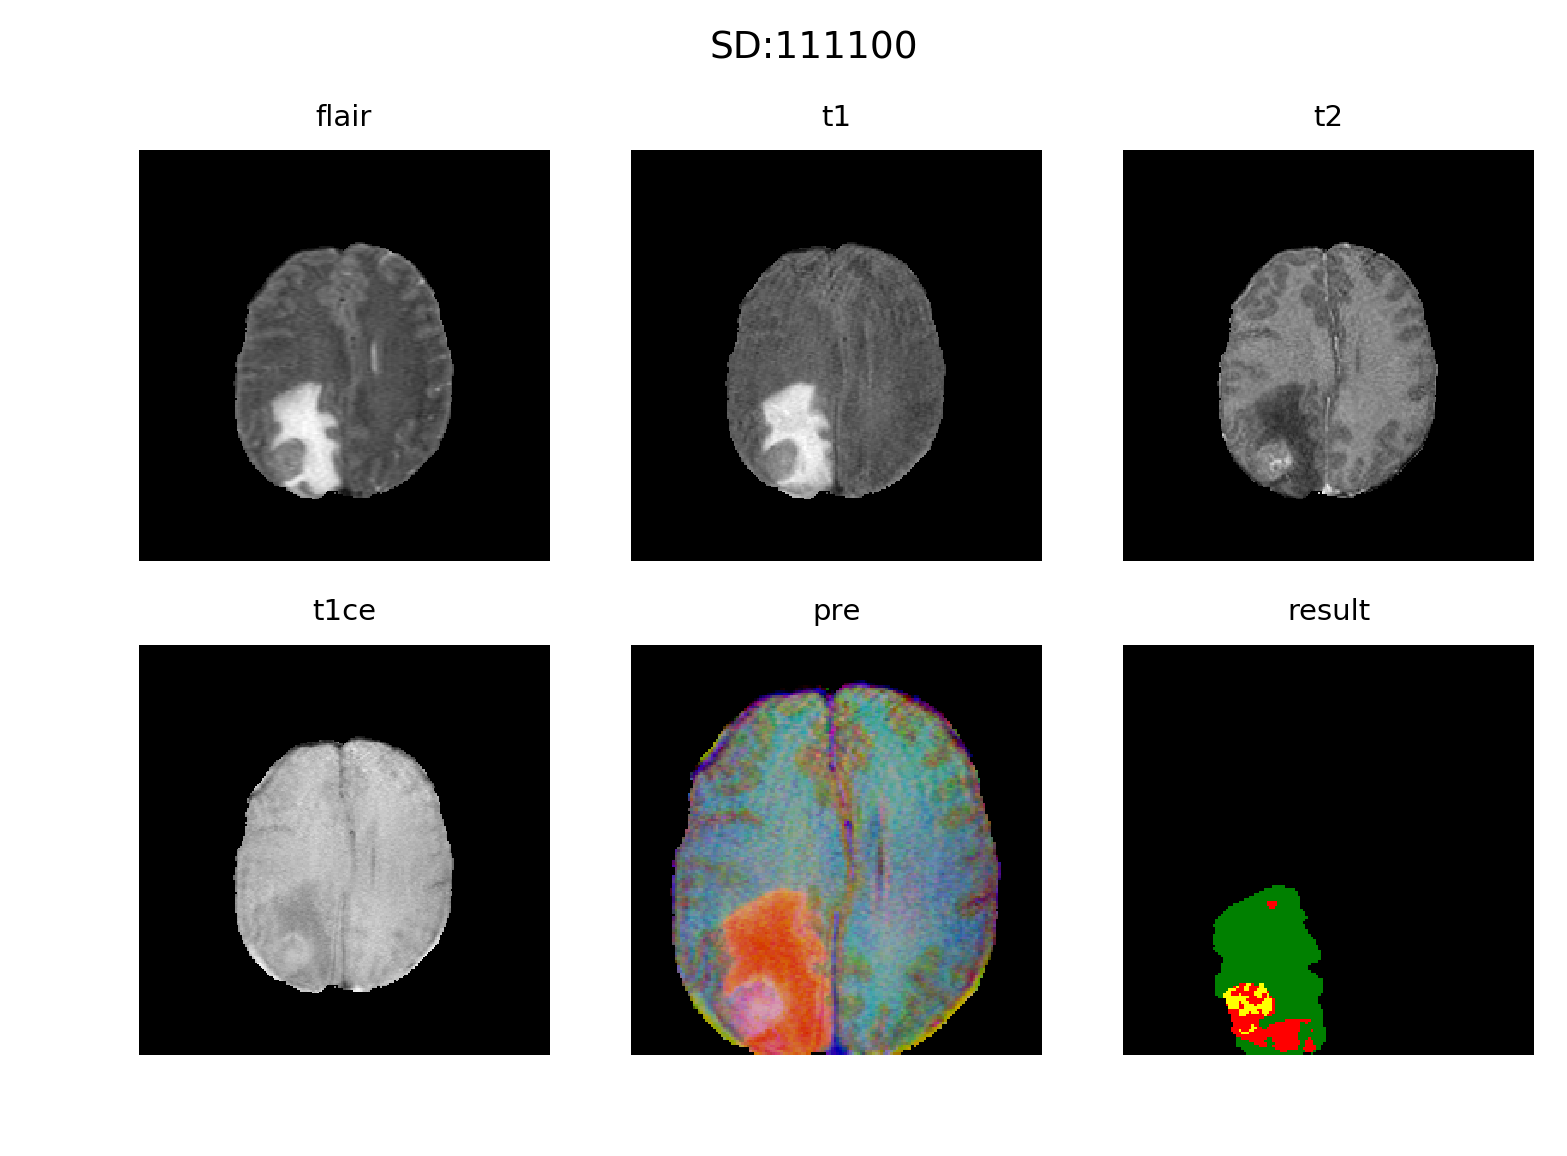

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


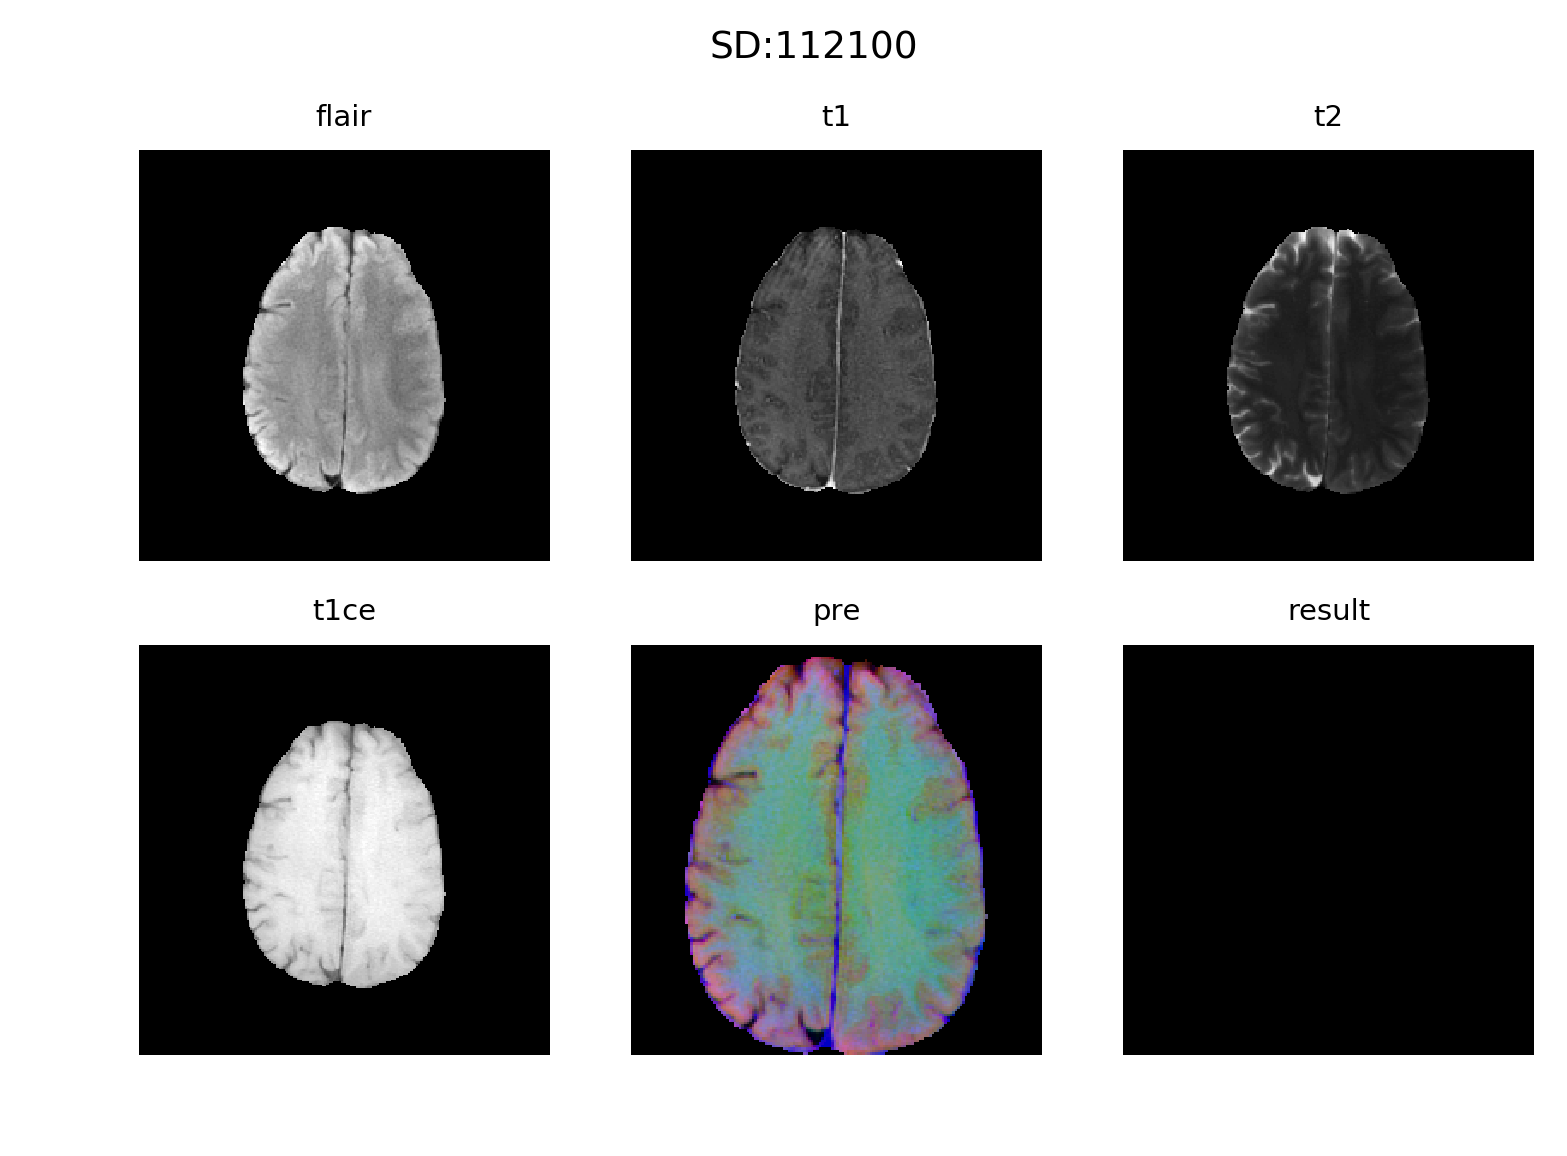

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


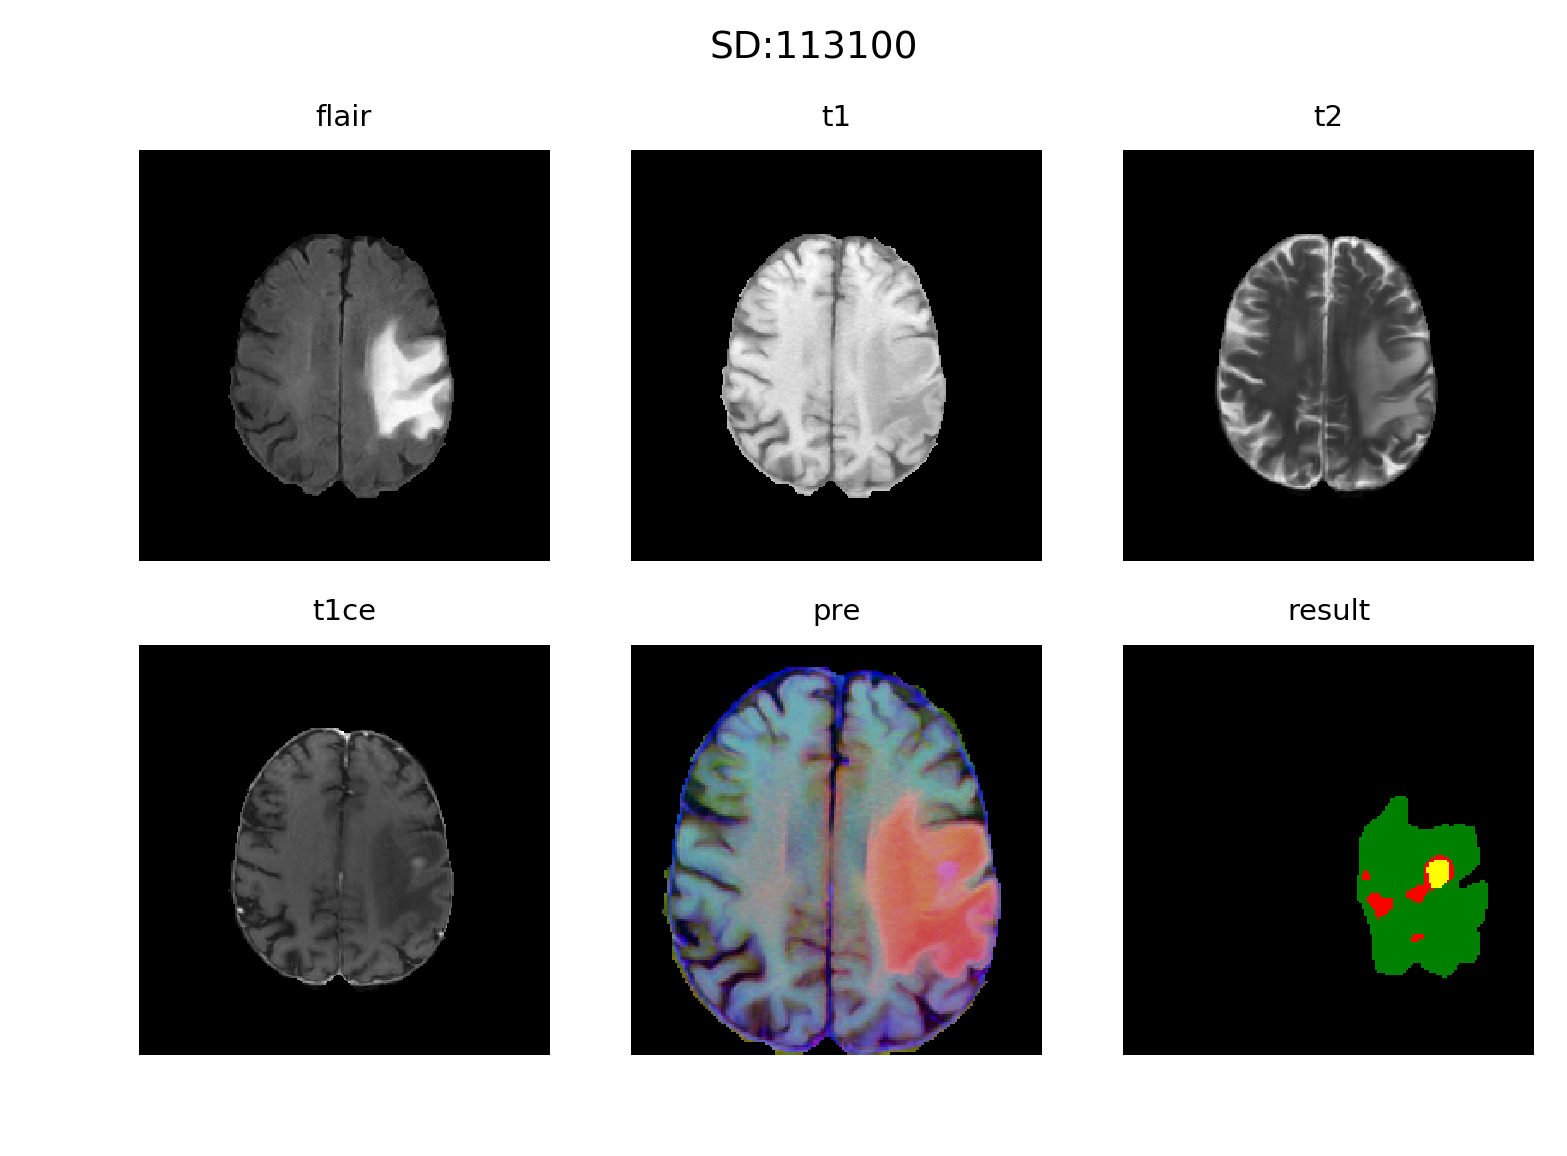

In [27]:
# dir_list=["{:0>3d}".format(i) for i in range(1,11)]
# print(img_data)
layer=100
update_data(img_data,dir_list,layer)
figure(img_data,layer)